# 流变性能预测模型 - 基于RandomForest的自定义版本

基于基线版本v2的修改：
1. 调整了异常数据的权重（tan_delta > 1000 时权重为0.01）
2. 增加了特征重要性分析
3. 添加了温度交互特征
4. 增加了预测结果的可视化

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
df = pd.read_csv("PB_Data.csv")

# 基本数据检查
required_cols = ['Sample_ID','Length_nm','Width_nm','Temp_C','Freq_rad_s','G1_Pa','G2_Pa']
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# 数据类型转换
for col in ['Length_nm','Width_nm','Temp_C','Freq_rad_s','G1_Pa','G2_Pa']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 删除关键列中的NaN值
df = df.dropna(subset=required_cols)

# 计算tan_delta并设置权重
df['tan_delta'] = df['G2_Pa'] / df['G1_Pa']
df['flag_suspicious'] = df['tan_delta'] > 1000
df['sample_weight'] = np.where(df['flag_suspicious'], 0.01, 1.0)  # 修改为0.01

# 保存处理后的数据
df.to_csv('PB_Data_filtered.csv', index=False)
print("已保存处理后的数据到 PB_Data_filtered.csv")

print(f"\n数据统计：")
print(f"总样本数: {len(df)}")
print(f"异常样本数 (tan_delta > 1000): {df['flag_suspicious'].sum()}")
print(f"唯一Sample_ID数量: {df['Sample_ID'].nunique()}")
print("\n温度分布:")
print(df['Temp_C'].value_counts().sort_index())

# 显示异常样本的详细信息
print("\n异常样本 (tan_delta > 1000) 的详细信息:")
suspicious_samples = df[df['flag_suspicious']].sort_values('tan_delta', ascending=False)
print(suspicious_samples[['Sample_ID', 'Length_nm', 'Width_nm', 'Temp_C', 'Freq_rad_s', 'G1_Pa', 'G2_Pa', 'tan_delta']])

Matplotlib is building the font cache; this may take a moment.


总样本数: 1875
异常样本数 (tan_delta > 1000): 161
唯一Sample_ID数量: 15

温度分布:
Temp_C
15    375
20    375
25    375
30    375
35    375
Name: count, dtype: int64


In [3]:
# 特征工程
df['Aspect'] = df['Length_nm'] / df['Width_nm']
df['log10_freq'] = np.log10(df['Freq_rad_s'])
df['log10_Gp'] = np.log10(df['G1_Pa'])
df['log10_Gpp'] = np.log10(df['G2_Pa'])
df['T_x_logf'] = df['Temp_C'] * df['log10_freq']
df['T_x_aspect'] = df['Temp_C'] * df['Aspect']  # 新增温度与长宽比的交互特征

feature_cols = ['Length_nm', 'Width_nm', 'Aspect', 'Temp_C', 
                'log10_freq', 'T_x_logf', 'T_x_aspect']
target_cols = ['log10_Gp', 'log10_Gpp']

X = df[feature_cols].values
y = df[target_cols].values
groups = df['Sample_ID'].values
weights = df['sample_weight'].values

# 构建模型管道
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MultiOutputRegressor(RandomForestRegressor(
        n_estimators=500,  # 增加树的数量
        max_depth=15,      # 限制树的深度以防过拟合
        min_samples_leaf=3,# 每个叶节点最少样本数
        random_state=42,
        n_jobs=-1
    )))
])

# 使用GroupKFold进行交叉验证
gkf = GroupKFold(n_splits=5)
cv_metrics = []

for fold, (train_idx, valid_idx) in enumerate(gkf.split(X, y, groups), 1):
    X_tr, X_va = X[train_idx], X[valid_idx]
    y_tr, y_va = y[train_idx], y[valid_idx]
    w_tr = weights[train_idx]
    
    pipe.fit(X_tr, y_tr, model__sample_weight=w_tr)
    y_pred = pipe.predict(X_va)
    
    # 计算评估指标
    metrics = {
        'fold': fold,
        'MAE_log10_Gp': mean_absolute_error(y_va[:,0], y_pred[:,0]),
        'MAE_log10_Gpp': mean_absolute_error(y_va[:,1], y_pred[:,1]),
        'R2_log10_Gp': r2_score(y_va[:,0], y_pred[:,0]),
        'R2_log10_Gpp': r2_score(y_va[:,1], y_pred[:,1])
    }
    cv_metrics.append(metrics)

cv_df = pd.DataFrame(cv_metrics)
print("\n交叉验证结果:")
print(cv_df.mean())


交叉验证结果:
fold             3.000000
MAE_log10_Gp     1.255055
MAE_log10_Gpp    0.824139
R2_log10_Gp      0.187822
R2_log10_Gpp     0.094361
dtype: float64


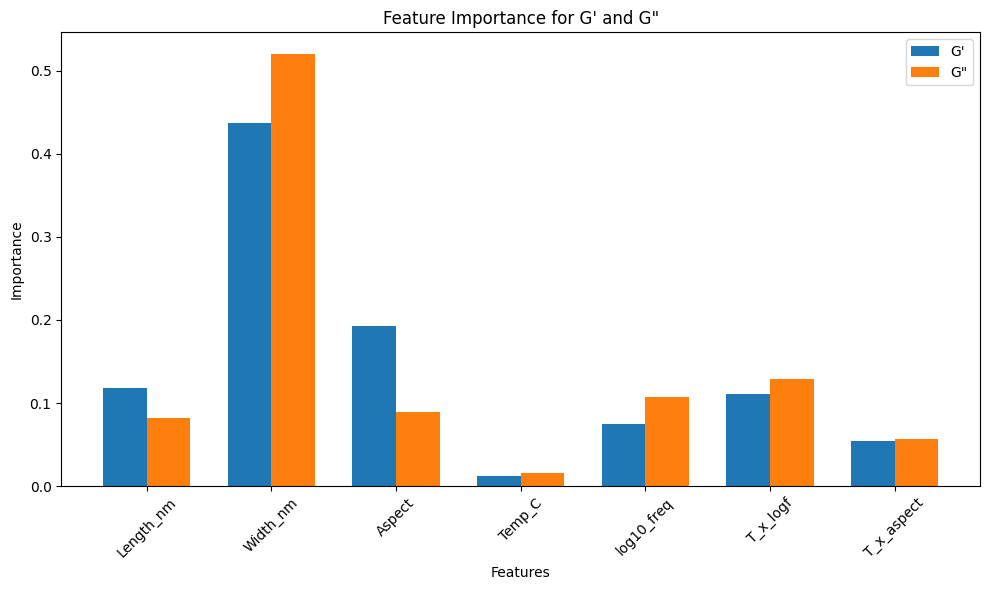


特征重要性排序:
      Feature  Importance_Gp  Importance_Gpp
1    Width_nm       0.436768        0.519953
2      Aspect       0.193126        0.089010
0   Length_nm       0.118130        0.081601
5    T_x_logf       0.110342        0.128680
4  log10_freq       0.075146        0.107806
6  T_x_aspect       0.054326        0.057331
3      Temp_C       0.012162        0.015619


In [4]:
# 特征重要性分析
pipe.fit(X, y, model__sample_weight=weights)
rf_model = pipe.named_steps['model']

# 获取每个目标的特征重要性
importance_gp = rf_model.estimators_[0].feature_importances_
importance_gpp = rf_model.estimators_[1].feature_importances_

# 创建特征重要性数据框
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance_Gp': importance_gp,
    'Importance_Gpp': importance_gpp
})

# 可视化特征重要性
plt.figure(figsize=(10, 6))
x = np.arange(len(feature_cols))
width = 0.35

plt.bar(x - width/2, importance_gp, width, label="G'")
plt.bar(x + width/2, importance_gpp, width, label='G"')
plt.xticks(x, feature_cols, rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance for G\' and G"')
plt.legend()
plt.tight_layout()
plt.show()

print("\n特征重要性排序:")
print(importance_df.sort_values('Importance_Gp', ascending=False))

In [6]:
# 预测新样本的函数
def predict_rheology(sample_data):
    """
    预测新样本的流变性能
    
    参数:
    sample_data: DataFrame，包含 Sample_ID, Length_nm, Width_nm, Temp_C, Freq_rad_s
    
    返回:
    DataFrame，包含预测结果和不确定性估计
    """
    # 特征工程
    sample_data['Aspect'] = sample_data['Length_nm'] / sample_data['Width_nm']
    sample_data['log10_freq'] = np.log10(sample_data['Freq_rad_s'])
    sample_data['T_x_logf'] = sample_data['Temp_C'] * sample_data['log10_freq']
    sample_data['T_x_aspect'] = sample_data['Temp_C'] * sample_data['Aspect']
    
    # 准备特征
    X_new = sample_data[feature_cols].values
    
    # 预测
    y_pred_log = pipe.predict(X_new)
    y_pred = 10**y_pred_log
    
    # 准备输出
    results = sample_data.copy()
    results['G1_Pa_pred'] = y_pred[:,0]
    results['G2_Pa_pred'] = y_pred[:,1]
    results['tan_delta_pred'] = results['G2_Pa_pred'] / results['G1_Pa_pred']
    
    return results

# 示例：预测新样本
new_samples = pd.DataFrame({
     "Sample_ID": ["411c","411c","411c","411c","411c","411c","411c","411c","411c","411c","411c","411c","411c","411c","411c"],
    "Length_nm": [300,300,300,300,300,300,300,300,300,300,300,300,300,300,300],
    "Width_nm": [20.94,20.94,20.94,20.94,20.94,20.94,20.94,20.94,20.94,20.94,20.94,20.94,20.94,20.94,20.94],
    "Temp_C": [25,25,25,25,25,25,25,25,25,25,25,25,25,25,25],
    "Freq_rad_s": [0.1, 0.127, 0.161, 0.204, 0.53, 1.08, 1.74, 2.81, 4.52, 9.24, 14.9, 24, 48.9, 78.8, 100],
})
predictions = predict_rheology(new_samples)
print("\n新样本预测结果:")
print(predictions[['Sample_ID', 'Length_nm', 'Width_nm', 'Temp_C', 
                  'Freq_rad_s', 'G1_Pa_pred', 'G2_Pa_pred', 'tan_delta_pred']])


新样本预测结果:
   Sample_ID  Length_nm  Width_nm  Temp_C  Freq_rad_s  G1_Pa_pred  G2_Pa_pred  \
0       411c        300     20.94      25       0.100    0.113039    0.639191   
1       411c        300     20.94      25       0.127    0.118042    0.638470   
2       411c        300     20.94      25       0.161    0.112381    0.651858   
3       411c        300     20.94      25       0.204    0.124025    0.749770   
4       411c        300     20.94      25       0.530    0.256191    1.052005   
5       411c        300     20.94      25       1.080    0.187470    1.536400   
6       411c        300     20.94      25       1.740    0.225348    2.069622   
7       411c        300     20.94      25       2.810    0.374108    3.179615   
8       411c        300     20.94      25       4.520    0.548199    4.291910   
9       411c        300     20.94      25       9.240    0.589387    6.509347   
10      411c        300     20.94      25      14.900    0.312584    9.916150   
11      411c      

In [ ]:
# 预测结果可视化
def plot_predictions(predictions, sample_id):
    sample_data = predictions[predictions['Sample_ID'] == sample_id]
    
    plt.figure(figsize=(12, 5))
    
    # G' 和 G" 随频率的变化
    plt.subplot(1, 2, 1)
    plt.semilogx(sample_data['Freq_rad_s'], sample_data['G1_Pa_pred'], 'o-', label="G'")
    plt.semilogx(sample_data['Freq_rad_s'], sample_data['G2_Pa_pred'], 's-', label='G"')
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('G\', G" (Pa)')
    plt.title(f'Sample {sample_id}: G\' and G" vs Frequency')
    plt.legend()
    plt.grid(True)
    
    # tan_delta 随频率的变化
    plt.subplot(1, 2, 2)
    plt.semilogx(sample_data['Freq_rad_s'], sample_data['tan_delta_pred'], 'o-')
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('tan(δ)')
    plt.title(f'Sample {sample_id}: tan(δ) vs Frequency')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# 为每个新样本绘制预测结果
for sample_id in predictions['Sample_ID'].unique():
    plot_predictions(predictions, sample_id)

## 使用说明

1. 数据要求：
   - 输入数据必须包含：Sample_ID, Length_nm, Width_nm, Temp_C, Freq_rad_s
   - G1_Pa (G') 和 G2_Pa (G") 为预测目标
   - tan_delta = G2_Pa / G1_Pa 用于数据质量控制

2. 模型特点：
   - 使用RandomForest进行多输出回归
   - 对异常数据(tan_delta > 1000)使用0.01的权重
   - 按Sample_ID分组进行交叉验证
   - 包含特征重要性分析
   
3. 预测功能：
   - 使用predict_rheology函数进行预测
   - 可视化函数用于展示预测结果
   
4. 评估指标：
   - MAE和R2分数（对数空间）
   - 交叉验证确保模型稳定性